In [1]:
import numpy as np

# Percorsi ai file
X = np.load("dataset_75/images.npy")
y = np.load("dataset_75/labels.npy")

X = X.astype("float32") / 255.0

X = X[..., np.newaxis]

print(X.shape)  # es. (18000, 150, 150) o (18000, 75, 75)
print(y.shape)  # es. (18000, 2)



(18000, 75, 75, 1)
(18000, 2)


In [2]:
label_range=5 #minutes the are togheter in the same class
number_of_classifiers=12*60//label_range

label=(y[:,0]*60 + y[:,1])//label_range

print(label[17999])
print(y[17999])
print(number_of_classifiers)

143
[11 59]
144


In [3]:
from sklearn.model_selection import train_test_split

X_traina, X_test, y_traina, y_test = train_test_split(X, label, test_size=0.1, random_state=42, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_traina, y_traina, test_size=y_test.shape[0], random_state=42, shuffle=True)

print(X_test.shape)
print(X_val.shape)
print(X_train.shape)
print(X_train[0].shape)

(1800, 75, 75, 1)
(1800, 75, 75, 1)
(14400, 75, 75, 1)
(75, 75, 1)


In [4]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras import layers, models, regularizers
from keras.optimizers import AdamW
from keras.callbacks import ReduceLROnPlateau


2025-10-24 15:03:10.268138: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-24 15:03:10.311445: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-24 15:03:12.948675: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
model_base = models.Sequential([
    keras.layers.Conv2D(32, (5,5), padding="same", input_shape=X_train[0].shape),
    keras.layers.BatchNormalization(),
    keras.layers.ReLU(),
    keras.layers.MaxPooling2D(),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(64, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(128, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),

    keras.layers.Conv2D(256, (3,3), padding="same", activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.AveragePooling2D(2,2),
    #keras.layers.Dropout(0.3),    

    keras.layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),
    layers.Dense(number_of_classifiers, activation="softmax")

])

/vol/home/s4949404/miniconda3/envs/IDL/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1761310994.489237 1017340 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3649 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9


In [6]:
model_base.compile(
    optimizer=AdamW(learning_rate=5e-4, weight_decay=5e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [7]:
# Reduce LR when validation loss stops improving
lr_scheduler = ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=5, min_lr=1e-6
)

checkpoint = keras.callbacks.ModelCheckpoint(
    "best_model.keras",
    save_best_only=True
)

early_stopping=keras.callbacks.EarlyStopping(
    patience=10,
    restore_best_weights=True
)

In [8]:
history_base = model_base.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler,checkpoint,early_stopping]
)


Epoch 1/50


2025-10-24 15:03:17.016846: I external/local_xla/xla/service/service.cc:163] XLA service 0x71473c007a80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-10-24 15:03:17.016860: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-10-24 15:03:17.065613: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-10-24 15:03:17.344641: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400
2025-10-24 15:03:17.466714: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-24 15:03:17.466743: I e

 12/225 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.0105 - loss: 5.0130

I0000 00:00:1761311004.094020 1017819 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


222/225 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0076 - loss: 5.0029

2025-10-24 15:03:27.762395: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-24 15:03:27.965250: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_221', 4 bytes spill stores, 4 bytes spill loads

2025-10-24 15:03:28.276707: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_221', 116 bytes spill stores, 116 bytes spill loads



225/225 ━━━━━━━━━━━━━━━━━━━━ 15s 30ms/step - accuracy: 0.0093 - loss: 4.9695 - val_accuracy: 0.0072 - val_loss: 5.3411 - learning_rate: 5.0000e-04
Epoch 2/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.0469 - loss: 4.3869 - val_accuracy: 0.0050 - val_loss: 11.9110 - learning_rate: 5.0000e-04
Epoch 3/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.1312 - loss: 3.3544 - val_accuracy: 0.0144 - val_loss: 6.7283 - learning_rate: 5.0000e-04
Epoch 4/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 17ms/step - accuracy: 0.2137 - loss: 2.7309 - val_accuracy: 0.2894 - val_loss: 2.4726 - learning_rate: 5.0000e-04
Epoch 5/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3005 - loss: 2.2710 - val_accuracy: 0.0700 - val_loss: 4.7161 - learning_rate: 5.0000e-04
Epoch 6/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.3895 - loss: 1.9148 - val_accuracy: 0.0333 - val_loss: 9.7988 - learning_rate: 5.0000e-04
Epoch 7/50
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - accuracy: 0.

In [9]:
# Carichiamo il modello salvato con i pesi migliori
best = keras.models.load_model("best_model.keras")

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_train, y_train)
print(f"Loss sul train set: {test_loss:.4f}")
print(f"Accuratezza sul train set: {test_acc:.4f}")

# Valutiamo sul test set
test_loss, test_acc = best.evaluate(X_test, y_test)
print(f"Loss sul test set: {test_loss:.4f}")
print(f"Accuratezza sul test set: {test_acc:.4f}")

2025-10-24 15:06:10.004966: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-24 15:06:10.004991: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2025-10-24 15:06:10.183106: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_208', 4 bytes spill stores, 4 bytes spill loads

2025-10-24 15:06:10.254652: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Re

450/450 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.9983 - loss: 0.0884
Loss sul train set: 0.0884
Accuratezza sul train set: 0.9983
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.8850 - loss: 0.3837
Loss sul test set: 0.3837
Accuratezza sul test set: 0.8850


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


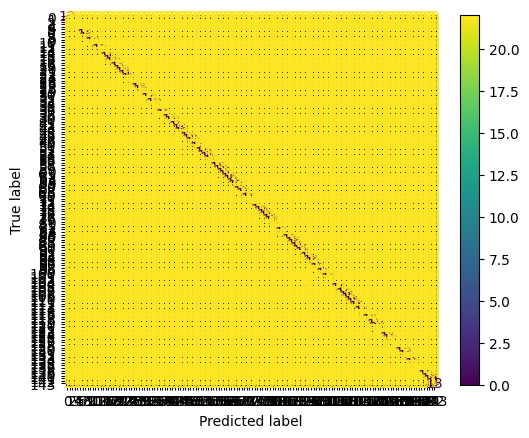

In [10]:
y_pred = model_base.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_classes)
ConfusionMatrixDisplay(cm).plot()




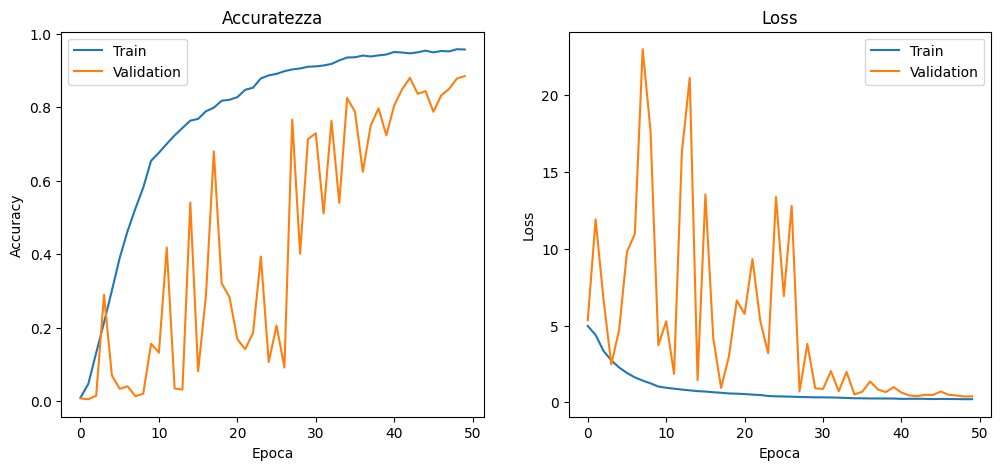

In [11]:
plt.figure(figsize=(12,5))

# Accuracy
plt.subplot(1,2,1)
plt.plot(history_base.history["accuracy"], label="Train")
plt.plot(history_base.history["val_accuracy"], label="Validation")
plt.title("Accuratezza")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1,2,2)
plt.plot(history_base.history["loss"], label="Train")
plt.plot(history_base.history["val_loss"], label="Validation")
plt.title("Loss")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()

plt.show()